In [47]:
import alpaca_trade_api as alpaca
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import hvplot.pandas

# Replace YOUR_API_KEY and YOUR_API_SECRET with your Alpaca API key and secret
alpaca_api = alpaca.REST('PKU5LEIDZZV83Y5ENASI', 'nvzOwJpyvr73GTitTDyga0MkI2Qd6RsK4PmhItbu', api_version='v2')

# Set the ticker symbol and time frame 
ticker = "XLY"
timeframe = "60Min"

# Set the start and end dates for the data
start_date = "2008-01-01T00:00:00-00:00"
end_date = "2022-12-31T00:00:00-00:00"

# Retrieve the data
data = alpaca_api.get_bars(ticker,  timeframe, start_date, end_date).df

# Convert the data to a Pandas dataframe
df = pd.DataFrame(data)

df['HH21']=df['high'].rolling(21).max()
df['LL21']=df['low'].rolling(21).min()
df['50Pct']=0.5*(df['HH21']-df['LL21'])
df['61Pct']=(1-0.615)*(df['HH21']-df['LL21'])

df['50R']=df['close']/df['50Pct']
df['61R']=df['close']/df['61Pct']


# Calculate the 3 period moving average of the close
df['Mid']=(df['high']+df['low'])/2
df['3dH']=(df['high'].rolling(3).max().shift(-3))-df['close']#Shift this before subtracting close!!!!!!!!
df['3dL']=df['close']-(df['low'].rolling(3).min().shift(-3))
df['RewardRisk']=df['3dH']/df['3dL']

df['CPctile']=(df['high']-df['close'])/(df['high']-df['low'])
df['OPctile']=(df['high']-df['open'])/(df['high']-df['low'])

df['Range']=df['high']-df['low']
df['RangeT']=(df['Range']-df['Range'].rolling(30).mean())/df['Range'].rolling(30).std()

# Calculate the 20 period moving average of the close
#df['20MA'] = df['close'].rolling(20).mean()

#df['RewardRisk']=df['RewardRisk'].shift(-3)




df['close']=df['close'].pct_change()
df['Mid']=df['Mid'].pct_change()
df=df.drop(columns=['open','high','low','volume','trade_count','vwap','3dH','3dL','Range'])
           
df["Signal"] = 0.0
           



In [48]:
dfCopy=df.copy()

dfCopy=dfCopy.reset_index()

display(dfCopy)


for index, row in dfCopy.iterrows():
    
    if index>2 and index<4:
        print(dfCopy.loc[index-1, 'close'] )
        print(dfCopy.loc[index-2, 'close'])
       
        

timestamp     close    HH21    LL21  50Pct    61Pct  \
0     2015-12-01 14:00:00+00:00       NaN     NaN     NaN    NaN      NaN   
1     2015-12-01 15:00:00+00:00 -0.000452     NaN     NaN    NaN      NaN   
2     2015-12-01 16:00:00+00:00 -0.000904     NaN     NaN    NaN      NaN   
3     2015-12-01 17:00:00+00:00  0.000531     NaN     NaN    NaN      NaN   
4     2015-12-01 18:00:00+00:00 -0.002339     NaN     NaN    NaN      NaN   
...                         ...       ...     ...     ...    ...      ...   
17783 2021-12-31 18:00:00+00:00  0.000229  176.54  173.91  1.315  1.01255   
17784 2021-12-31 19:00:00+00:00 -0.000516  176.54  173.91  1.315  1.01255   
17785 2021-12-31 20:00:00+00:00 -0.002181  176.54  173.79  1.375  1.05875   
17786 2021-12-31 21:00:00+00:00  0.000691  176.54  173.79  1.375  1.05875   
17787 2021-12-31 22:00:00+00:00  0.000517  176.54  173.79  1.375  1.05875   

              50R         61R       Mid  RewardRisk   CPctile   OPctile  \
0             NaN         NaN       NaN    0.136364  0.035714  0.571429   
1             NaN         NaN  0.000793    0.181984  0.200000  0.120000   
2             NaN         NaN  0.000904    0.321802  0.538106  0.230177   
3             NaN         NaN  0.000171    0.720568  0.300000  0.545455   
4             NaN         NaN -0.001348         inf  0.712897  0.000000   
...           ...         ...       ...         ...       ...       ...   
17783  132.585551  172.189028  0.001177    0.392857  0.444444  0.583333   
17784  132.517110  172.100143 -0.000258    0.659574  0.571429  0.314286   
17785  126.458109  164.231311 -0.000602         NaN  0.884744  0.384615   
17786  126.545455  164.344746 -0.001407         NaN  0.000000  1.000000   
17787  126.610909  164.429752  0.000891         NaN       NaN       NaN   

         RangeT  Signal  
0           NaN     0.0  
1           NaN     0.0  
2           NaN     0.0  
3           NaN     0.0  
4           NaN     0.0  
...         ...     ...  
17783 -0.309324     0.0  
17784 -0.282052     0.0  
17785  1.169708     0.0  
17786 -0.915880     0.0  
17787 -1.266390     0.0  

[17788 rows x 14 columns]

-0.0009035464196974763
-0.00045156920298028425


In [49]:
for index, row in df.iterrows():
    if row["Mid"] >= 0:
       df.loc[index, "Signal"] = 1.0
    if row["Mid"] < 0:
        df.loc[index,"Signal"] = 0.0
        
'''for index, row in df.iterrows():
    if row["RewardRisk"] >= 2:
       df.loc[index, "Signal"] = 1.0
    if row["RewardRisk"] < 2:
        df.loc[index,"Signal"] = 0.0'''
# Calculate the points in time at which a position should be taken, 1 or -1
#ema_signals_df['Crossover']= ema_signals_df['Signal'].diff()
#ema_signals_df=ema_signals_df.dropna()
#ema_signals_df['Crossover']=ema_signals_df['Crossover'].shift(-8)
df["Signal"]=df["Signal"].shift(-1)
df['FutureSlope']=df["Mid"].shift(-1)
#df['RR']=df["RewardRisk"]

'''ema_signals_df['Crossover']=ema_signals_df['Signal'].diff()
# Review the DataFrame
#ema_signals_df=ema_signals_df['Crossover'].dropna()
ema_signals_df=ema_signals_df.dropna()'''
df.tail(100)

close     HH21    LL21   50Pct     61Pct  \
timestamp                                                                
2021-12-21 16:00:00+00:00  0.005827  167.840  164.36  1.7400  1.339800   
2021-12-21 17:00:00+00:00  0.005435  168.380  164.36  2.0100  1.547700   
2021-12-21 18:00:00+00:00  0.003225  168.940  164.36  2.2900  1.763300   
2021-12-21 19:00:00+00:00  0.004926  169.725  164.36  2.6825  2.065525   
2021-12-21 20:00:00+00:00  0.000088  169.900  164.36  2.7700  2.132900   
...                             ...      ...     ...     ...       ...   
2021-12-31 18:00:00+00:00  0.000229  176.540  173.91  1.3150  1.012550   
2021-12-31 19:00:00+00:00 -0.000516  176.540  173.91  1.3150  1.012550   
2021-12-31 20:00:00+00:00 -0.002181  176.540  173.79  1.3750  1.058750   
2021-12-31 21:00:00+00:00  0.000691  176.540  173.79  1.3750  1.058750   
2021-12-31 22:00:00+00:00  0.000517  176.540  173.79  1.3750  1.058750   

                                  50R         61R       Mid  RewardRisk  \
timestamp                                                                 
2021-12-21 16:00:00+00:00   96.229885  124.973877  0.004603   13.958461   
2021-12-21 17:00:00+00:00   83.756219  108.774310  0.004474    7.948718   
2021-12-21 18:00:00+00:00   73.752402   95.782340  0.004286   30.515152   
2021-12-21 19:00:00+00:00   63.271202   82.170393  0.004420    0.222930   
2021-12-21 20:00:00+00:00   61.277978   79.581790  0.000753    0.190476   
...                               ...         ...       ...         ...   
2021-12-31 18:00:00+00:00  132.585551  172.189028  0.001177    0.392857   
2021-12-31 19:00:00+00:00  132.517110  172.100143 -0.000258    0.659574   
2021-12-31 20:00:00+00:00  126.458109  164.231311 -0.000602         NaN   
2021-12-31 21:00:00+00:00  126.545455  164.344746 -0.001407         NaN   
2021-12-31 22:00:00+00:00  126.610909  164.429752  0.000891         NaN   

                            CPctile   OPctile    RangeT  Signal  FutureSlope  
timestamp                                                                     
2021-12-21 16:00:00+00:00  0.235485  0.941938  1.017000     1.0     0.004474  
2021-12-21 17:00:00+00:00  0.027181  0.833560  0.713699     1.0     0.004286  
2021-12-21 18:00:00+00:00  0.059873  0.751592  0.092724     1.0     0.004420  
2021-12-21 19:00:00+00:00  0.000000  0.953757  0.319780     1.0     0.000753  
2021-12-21 20:00:00+00:00  0.166667  0.187500  0.530129     1.0     0.001328  
...                             ...       ...       ...     ...          ...  
2021-12-31 18:00:00+00:00  0.444444  0.583333 -0.309324     0.0    -0.000258  
2021-12-31 19:00:00+00:00  0.571429  0.314286 -0.282052     0.0    -0.000602  
2021-12-31 20:00:00+00:00  0.884744  0.384615  1.169708     0.0    -0.001407  
2021-12-31 21:00:00+00:00  0.000000  1.000000 -0.915880     1.0     0.000891  
2021-12-31 22:00:00+00:00       NaN       NaN -1.266390     NaN          NaN  

[100 rows x 14 columns]

In [50]:
df.tail(100)

close     HH21    LL21   50Pct     61Pct  \
timestamp                                                                
2021-12-21 16:00:00+00:00  0.005827  167.840  164.36  1.7400  1.339800   
2021-12-21 17:00:00+00:00  0.005435  168.380  164.36  2.0100  1.547700   
2021-12-21 18:00:00+00:00  0.003225  168.940  164.36  2.2900  1.763300   
2021-12-21 19:00:00+00:00  0.004926  169.725  164.36  2.6825  2.065525   
2021-12-21 20:00:00+00:00  0.000088  169.900  164.36  2.7700  2.132900   
...                             ...      ...     ...     ...       ...   
2021-12-31 18:00:00+00:00  0.000229  176.540  173.91  1.3150  1.012550   
2021-12-31 19:00:00+00:00 -0.000516  176.540  173.91  1.3150  1.012550   
2021-12-31 20:00:00+00:00 -0.002181  176.540  173.79  1.3750  1.058750   
2021-12-31 21:00:00+00:00  0.000691  176.540  173.79  1.3750  1.058750   
2021-12-31 22:00:00+00:00  0.000517  176.540  173.79  1.3750  1.058750   

                                  50R         61R       Mid  RewardRisk  \
timestamp                                                                 
2021-12-21 16:00:00+00:00   96.229885  124.973877  0.004603   13.958461   
2021-12-21 17:00:00+00:00   83.756219  108.774310  0.004474    7.948718   
2021-12-21 18:00:00+00:00   73.752402   95.782340  0.004286   30.515152   
2021-12-21 19:00:00+00:00   63.271202   82.170393  0.004420    0.222930   
2021-12-21 20:00:00+00:00   61.277978   79.581790  0.000753    0.190476   
...                               ...         ...       ...         ...   
2021-12-31 18:00:00+00:00  132.585551  172.189028  0.001177    0.392857   
2021-12-31 19:00:00+00:00  132.517110  172.100143 -0.000258    0.659574   
2021-12-31 20:00:00+00:00  126.458109  164.231311 -0.000602         NaN   
2021-12-31 21:00:00+00:00  126.545455  164.344746 -0.001407         NaN   
2021-12-31 22:00:00+00:00  126.610909  164.429752  0.000891         NaN   

                            CPctile   OPctile    RangeT  Signal  FutureSlope  
timestamp                                                                     
2021-12-21 16:00:00+00:00  0.235485  0.941938  1.017000     1.0     0.004474  
2021-12-21 17:00:00+00:00  0.027181  0.833560  0.713699     1.0     0.004286  
2021-12-21 18:00:00+00:00  0.059873  0.751592  0.092724     1.0     0.004420  
2021-12-21 19:00:00+00:00  0.000000  0.953757  0.319780     1.0     0.000753  
2021-12-21 20:00:00+00:00  0.166667  0.187500  0.530129     1.0     0.001328  
...                             ...       ...       ...     ...          ...  
2021-12-31 18:00:00+00:00  0.444444  0.583333 -0.309324     0.0    -0.000258  
2021-12-31 19:00:00+00:00  0.571429  0.314286 -0.282052     0.0    -0.000602  
2021-12-31 20:00:00+00:00  0.884744  0.384615  1.169708     0.0    -0.001407  
2021-12-31 21:00:00+00:00  0.000000  1.000000 -0.915880     1.0     0.000891  
2021-12-31 22:00:00+00:00       NaN       NaN -1.266390     NaN          NaN  

[100 rows x 14 columns]

In [51]:
#display(df.hvplot.scatter(y='CloseDiff3MA',x='3MASlope'))

lstColumns=df.columns

display(lstColumns)

dfopt=pd.DataFrame()

'''for column in lstColumns:
    display(df.hvplot.scatter(y='FutureSlope',x=column))
    dfopt=df[['FutureSlope',column]]
    display(dfopt.corr())'''
    
for column in lstColumns:
    display(df.hvplot.scatter(y='FutureSlope',x=column))
    dfopt=df[['FutureSlope',column]]
    display(dfopt.corr())

Index(['close', 'HH21', 'LL21', '50Pct', '61Pct', '50R', '61R', 'Mid',
       'RewardRisk', 'CPctile', 'OPctile', 'RangeT', 'Signal', 'FutureSlope'],
      dtype='object')

:Scatter   [close]   (FutureSlope)

FutureSlope     close
FutureSlope     1.000000  0.326035
close           0.326035  1.000000

:Scatter   [HH21]   (FutureSlope)

FutureSlope      HH21
FutureSlope     1.000000 -0.000681
HH21           -0.000681  1.000000

:Scatter   [LL21]   (FutureSlope)

FutureSlope      LL21
FutureSlope     1.000000 -0.000663
LL21           -0.000663  1.000000

:Scatter   [50Pct]   (FutureSlope)

FutureSlope     50Pct
FutureSlope     1.000000 -0.000721
50Pct          -0.000721  1.000000

:Scatter   [61Pct]   (FutureSlope)

FutureSlope     61Pct
FutureSlope     1.000000 -0.000721
61Pct          -0.000721  1.000000

:Scatter   [50R]   (FutureSlope)

FutureSlope       50R
FutureSlope     1.000000  0.001339
50R             0.001339  1.000000

:Scatter   [61R]   (FutureSlope)

FutureSlope       61R
FutureSlope     1.000000  0.001339
61R             0.001339  1.000000

:Scatter   [Mid]   (FutureSlope)

FutureSlope       Mid
FutureSlope     1.000000  0.109193
Mid             0.109193  1.000000

:Scatter   [RewardRisk]   (FutureSlope)

FutureSlope  RewardRisk
FutureSlope     1.000000    0.010272
RewardRisk      0.010272    1.000000

:Scatter   [CPctile]   (FutureSlope)

FutureSlope   CPctile
FutureSlope     1.000000 -0.355198
CPctile        -0.355198  1.000000

:Scatter   [OPctile]   (FutureSlope)

FutureSlope   OPctile
FutureSlope     1.000000  0.175282
OPctile         0.175282  1.000000

:Scatter   [RangeT]   (FutureSlope)

FutureSlope    RangeT
FutureSlope     1.000000 -0.035709
RangeT         -0.035709  1.000000

:Scatter   [Signal]   (FutureSlope)

FutureSlope    Signal
FutureSlope     1.000000  0.603755
Signal          0.603755  1.000000

:Scatter   [FutureSlope]   (FutureSlope)

FutureSlope  FutureSlope
FutureSlope          1.0          1.0
FutureSlope          1.0          1.0

In [52]:
df=df.dropna()

y = df['Signal']

# Review the value counts
y.value_counts()

1.0    8501
0.0    7052
Name: Signal, dtype: int64

In [53]:
# Select the start of the training period

from datetime import datetime
from pandas.tseries.offsets import DateOffset
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report

X = df[['50Pct','61Pct','RangeT','OPctile','CPctile']].dropna()




training_begin = X.index.min()

# Display the training begin date
print(training_begin)

training_end = X.index.min() + DateOffset(months=71)

# Display the training end date
print(training_end)

# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
display(X_train.head())
display(X_train.tail())

# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end+DateOffset(hours=1):]
y_test = y.loc[training_end+DateOffset(hours=1):]

# Review the X_test DataFrame
X_test.head()

# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

2015-12-04 16:00:00+00:00
2021-11-04 16:00:00+00:00


50Pct     61Pct    RangeT   OPctile   CPctile
timestamp                                                                
2015-12-04 16:00:00+00:00  0.6375  0.490875 -0.337330  0.066622  0.599600
2015-12-04 17:00:00+00:00  0.6375  0.490875  0.902848  0.864407  0.033898
2015-12-04 18:00:00+00:00  0.6375  0.490875 -0.642672  0.909091  0.136364
2015-12-04 19:00:00+00:00  0.6650  0.512050 -0.224093  0.693750  0.062500
2015-12-04 20:00:00+00:00  0.6775  0.521675 -0.386420  0.206897  0.586207

50Pct    61Pct    RangeT   OPctile   CPctile
timestamp                                                              
2021-11-04 12:00:00+00:00  1.230  0.94710 -0.205534  0.933333  0.900000
2021-11-04 13:00:00+00:00  1.630  1.25510  2.319325  0.793893  0.038168
2021-11-04 14:00:00+00:00  1.945  1.49765  0.877356  0.883117  0.428571
2021-11-04 15:00:00+00:00  1.945  1.49765  0.544946  0.200000  0.084615
2021-11-04 16:00:00+00:00  2.000  1.54000  0.207400  0.742268  0.577320

In [54]:
# From SVM, instantiate SVC classifier model instance
svm_model = svm.SVC(probability=True) 
# Fit the model to the data using the training data
svm_model = svm_model.fit(X_train_scaled, y_train)
# Use the testing data to make the model predictions
svm_pred = svm_model.predict(X_test_scaled)

# Review the model's predicted values
svm_pred

# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_test, svm_pred)

# Print the classification report
print(svm_testing_report)


              precision    recall  f1-score   support

         0.0       0.67      0.59      0.63       232
         1.0       0.68      0.75      0.72       270

    accuracy                           0.68       502
   macro avg       0.68      0.67      0.67       502
weighted avg       0.68      0.68      0.68       502



In [55]:
4991/9151

0.5454048737842858

/Users/saibal/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


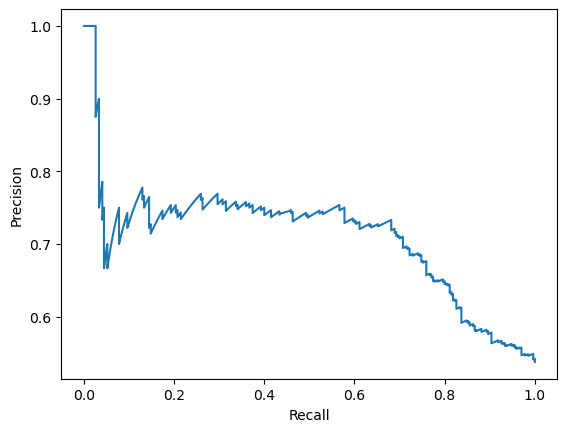

In [56]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np


y_probs = svm_model.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Plot the precision-recall curve
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

# Find the threshold with the highest F1 score
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold_index = np.argmax(precision)
best_threshold = thresholds[best_threshold_index]

# Make predictions with the best threshold
y_pred = (y_probs <= best_threshold).astype(int)

In [57]:
print(best_threshold)

print(np.argmax(precision))

svm_testing_report = classification_report(y_test, y_pred)

# Print the classification report
print(svm_testing_report)

0.626886283110032
490
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       232
         1.0       0.53      0.98      0.69       270

    accuracy                           0.53       502
   macro avg       0.27      0.49      0.34       502
weighted avg       0.29      0.53      0.37       502



In [58]:
X_test

50Pct    61Pct    RangeT   OPctile   CPctile
timestamp                                                              
2021-11-04 17:00:00+00:00  2.150  1.65550  1.005778  0.753247  0.038961
2021-11-04 18:00:00+00:00  2.290  1.76330  0.674352  0.492308  0.769231
2021-11-04 19:00:00+00:00  2.290  1.76330  0.708547  0.358209  0.134328
2021-11-04 20:00:00+00:00  2.290  1.76330 -0.456745  0.958333  0.208333
2021-11-04 21:00:00+00:00  2.250  1.73250 -0.309000  1.000000  0.000000
...                          ...      ...       ...       ...       ...
2021-12-31 15:00:00+00:00  1.260  0.97020  0.875128  0.475000  0.506250
2021-12-31 16:00:00+00:00  1.260  0.97020 -0.102756  0.232558  0.790698
2021-12-31 17:00:00+00:00  1.315  1.01255 -0.136582  0.348837  0.069767
2021-12-31 18:00:00+00:00  1.315  1.01255 -0.309324  0.583333  0.444444
2021-12-31 19:00:00+00:00  1.315  1.01255 -0.282052  0.314286  0.571429

[502 rows x 5 columns]

In [59]:
for x in range(1,100,1):
    threshold=float(x)/100
    print(threshold)
    y_pred = (y_probs >= threshold).astype(int)
    svm_testing_report = classification_report(y_test, y_pred)

    # Print the classification report
    print(svm_testing_report)
    
    

0.01
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       232
         1.0       0.54      1.00      0.70       270

    accuracy                           0.54       502
   macro avg       0.27      0.50      0.35       502
weighted avg       0.29      0.54      0.38       502

0.02
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       232
         1.0       0.54      1.00      0.70       270

    accuracy                           0.54       502
   macro avg       0.27      0.50      0.35       502
weighted avg       0.29      0.54      0.38       502

0.03
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       232
         1.0       0.54      1.00      0.70       270

    accuracy                           0.54       502
   macro avg       0.27      0.50      0.35       502
weighted avg       0.29      0.54      0.38       502

0.04

/Users/saibal/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/saibal/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/saibal/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/saibal/op